In [1]:
import os
import sys
import json
from datetime import datetime

import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

In [2]:
# Add the `src` folder to the Python path
current_dir = os.getcwd() 
src_path = os.path.join(current_dir, 'src')
sys.path.append(src_path)

import environment_gym as env_gym
import environment_gym_rs2 as env_gym_rs2
import utilities as util
print("Modules imported successfully!")
# Load the TensorBoard extension
# %reload_ext tensorboard

Modules imported successfully!


## Reward Shaping Method 2

- Apply reward (150 * new clearance rate) to good lane switch
- Apply penalty to impossible lane switch (switch left when lane = 1 and switch right when lane = 5)

### Train Model 4

In [3]:
# Initialize and vectorize the environment
env = env_gym_rs2.TrafficEnvironment(reward_shaping_flag=True)
check_env(env, warn=True)
env.reset()
eval_env = Monitor(env_gym_rs2.TrafficEnvironment(reward_shaping_flag=False))

# Set up log directory
log_dir = "./logs/dqn_rs2_model/"
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = DQN(policy = "MlpPolicy",
            env = env, 
            verbose = 1,
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-5744.00 +/- 8543.50
Episode length: 947.20 +/- 812.66
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 947       |
|    mean_reward      | -5.74e+03 |
| rollout/            |           |
|    exploration_rate | 0.81      |
| time/               |           |
|    total_timesteps  | 1000      |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 3.31      |
|    n_updates        | 224       |
-----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=2152.00 +/- 644.71
Episode length: 184.80 +/- 64.47
----------------------------------
| eval/               |          |
|    mean_ep_length   | 185      |
|    mean_reward      | 2.15e+03 |
| rollout/            |          |
|    exploration_rate | 0.62     |
| time/           

### Test Model 4

In [4]:
# Load the best baseline model
log_dir = "./logs/dqn_rs2_model/"
model_path = log_dir + 'best_model/best_model.zip'
model = DQN.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [5]:
# Test the model
num_episodes = 1000
file_name = 'dqn_rs2_best_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

Average reward of 1000 episodes is -5677.
Average timesteps of 1000 episodes is 959.


### Analysis of Model 4

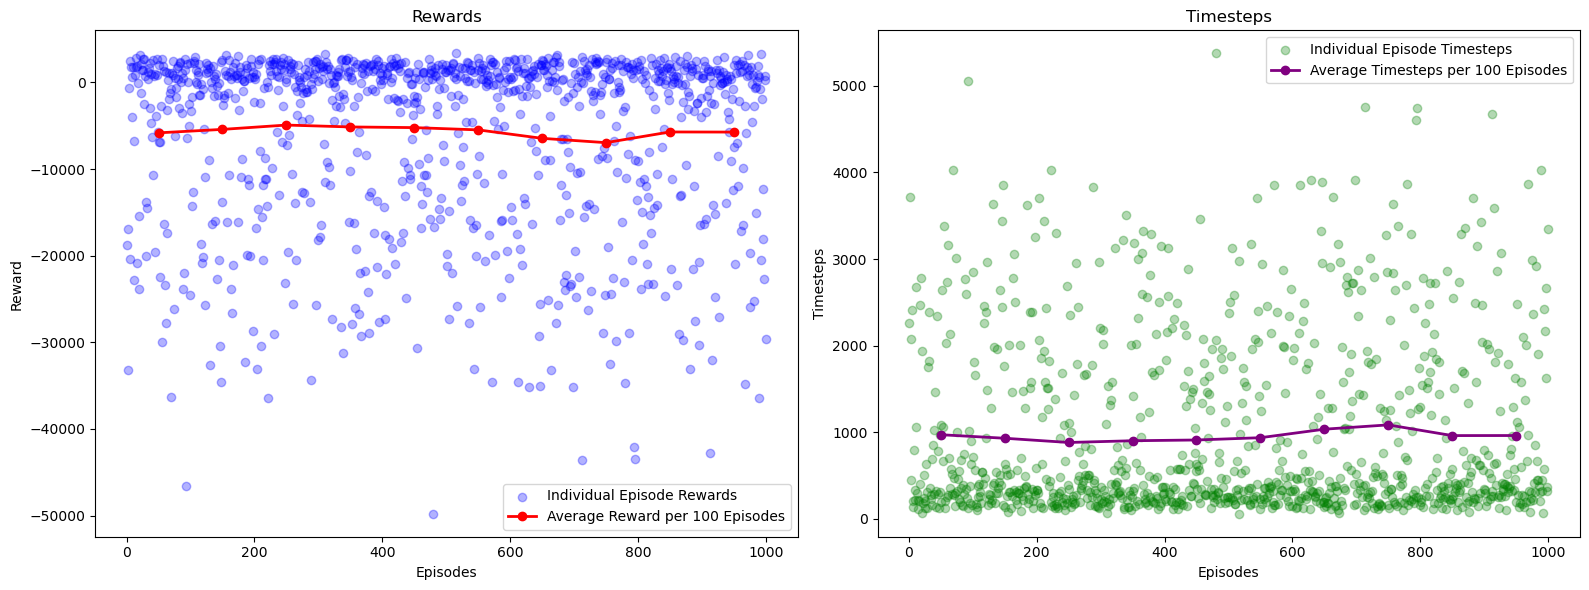

In [6]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=100)

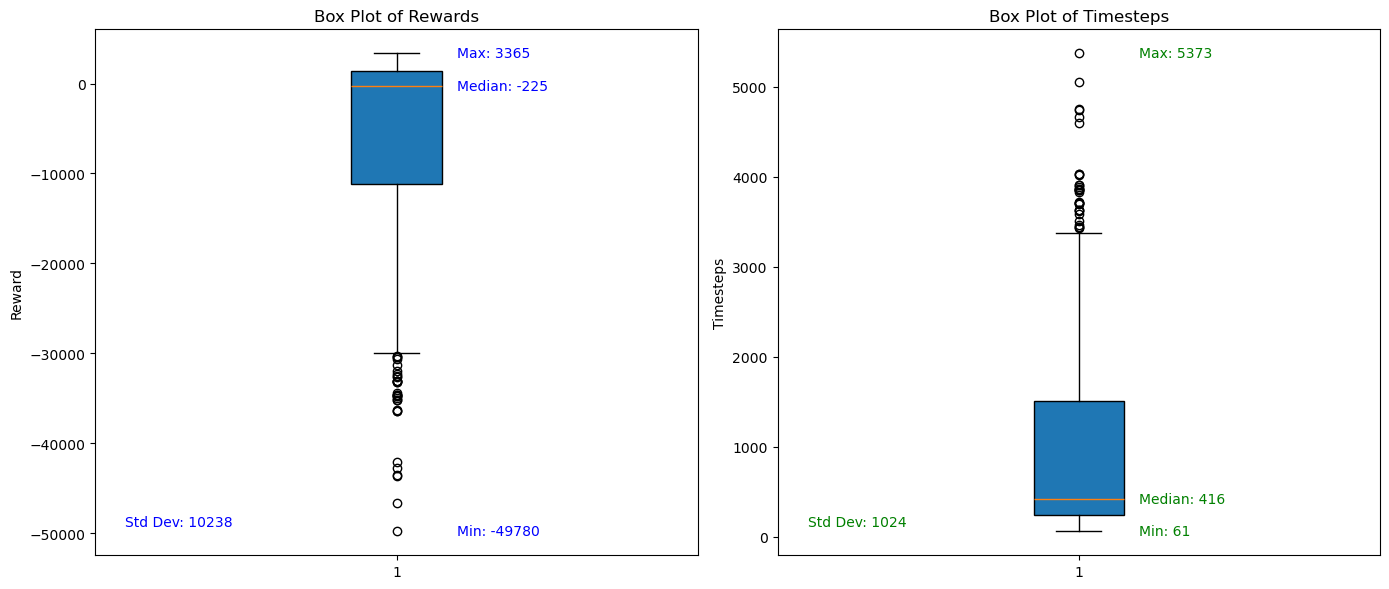

In [7]:
util.plot_test_boxplots(json_file=file_name)

In [8]:
util.calculate_action_percentages(log_file=file_name)
print("")
util.calculate_clearance_rate_percentages(log_file=file_name)

Total actions across 1000 episodes: 958709
Action -1: 0.2%
Action 0: 98.1%
Action 1: 1.7%

Total timesteps across 1000 episodes (including initial states): 959709
Lane 1:
  76.2% of timesteps had a clearance rate less than 5
  86.6% of timesteps had a clearance rate less than 10
Lane 2:
  75.8% of timesteps had a clearance rate less than 5
  86.5% of timesteps had a clearance rate less than 10
Lane 3:
  75.7% of timesteps had a clearance rate less than 5
  86.6% of timesteps had a clearance rate less than 10
Lane 4:
  75.9% of timesteps had a clearance rate less than 5
  86.7% of timesteps had a clearance rate less than 10
Lane 5:
  76.3% of timesteps had a clearance rate less than 5
  86.9% of timesteps had a clearance rate less than 10


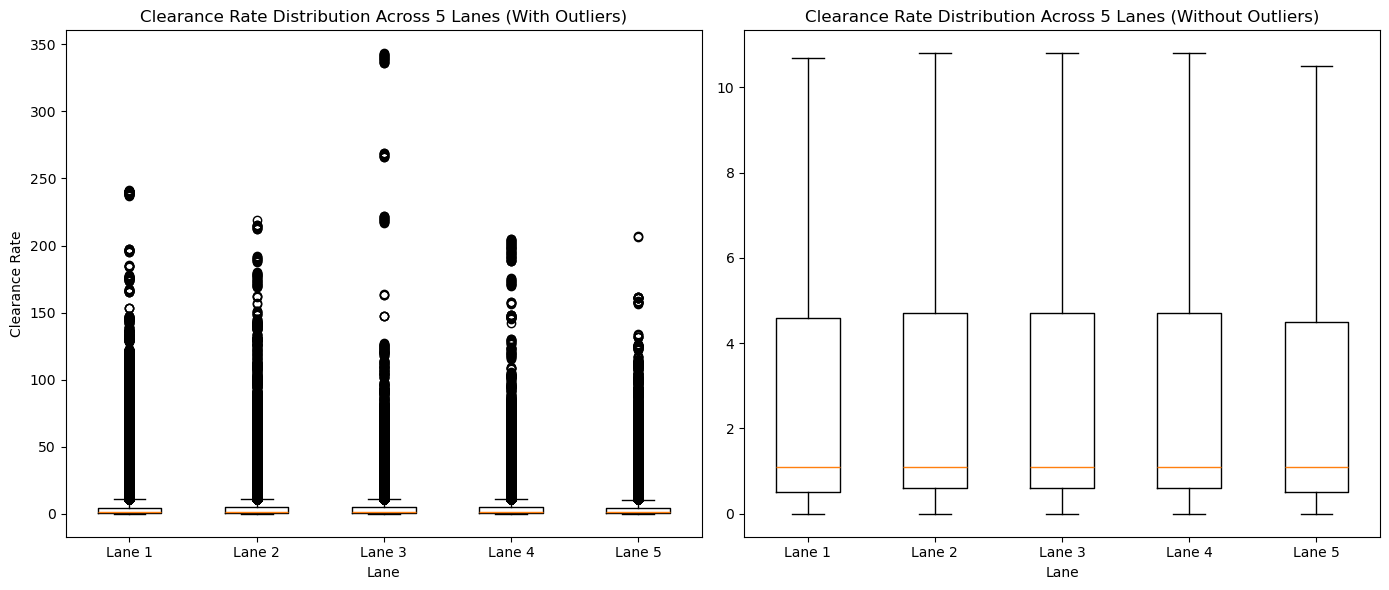

In [9]:
util.plot_clearance_rate_boxplots(log_file=file_name)